<a href="https://colab.research.google.com/github/NguyenDucAnforwork/NLP_training/blob/main/Copy_of_HAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This dataset is fetched from:
https://www.kaggle.com/datasets/jarupula/yahoo-answers-dataset

## I use pretrained model Glove for vector embeddings with 50 dimensions

In [1]:
ls

glove.6B.50d.txt  sample_data/  test.csv  train.csv


In [2]:
#@title install necessary libraries
!pip install gensim

In [3]:
#@title configuration
config = {
    "max_num_sent" : 4,
    "max_sent_len" : 64,
    "embed_dim" : 50,
    "batch_size" : 16,
    "sent_hidden_size" : 25,
    "doc_hidden_size" : 25,
    "context_size1" : 20,
    "context_size2" : 20,
    "hidden_size" : 20,
    "num_class" : 10
}

In [4]:
#@title import libraries + declaring necessary parameters
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import gensim.downloader as api
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import re, nltk
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import csv
import nltk
from torchvision import models
from torchsummary import summary
from bs4 import BeautifulSoup
from torch.utils.data import Dataset, DataLoader

### read data + pretrained model


In [5]:
# convert word to vector embedding from pretrained model
file_path = './glove.6B.50d.txt'

vocab = {}

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split()
        word = parts[0]

        vector = torch.tensor([float(val) if val != '-' else 0 for val in parts[1:]])
        vocab[word] = vector

In [6]:
def read_data(datapath):
    documents, labels = [], []
    with open(datapath, encoding='latin-1') as csv_file:
        reader = csv.reader(csv_file, quotechar='"')
        for idx, line in enumerate(reader):
            if (line[0] == ""):
                break
            text = ""
            for tx in line[1:]:
                feature_cleaned = tx.replace('"', '').replace('\\n', ' ').replace('\\', ' ').replace(',', ' ')
                text += feature_cleaned.lower()
                text += " "
            label = int(line[0]) - 1

            if text:
                documents.append(text)
            labels.append(label)
    return documents, labels
train_docs, train_labels = read_data("./train.csv")
test_docs, test_labels = read_data("./test.csv")

### preprocessing

In [7]:
# remove html tag, split doc into sentences; sentences into word => padding them to be the same length
nltk.download('punkt')

def split_into_sentences(document):
    document = re.sub(r"[\[\]']", "", document)
    sentences = re.split(r"[.!?,]", document)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences


def preprocess(document):
    sentences = split_into_sentences(document)
    sentence_embeddings = []

    for sentence in sentences:
        sentence_embedding = []
        for word in sentence:
            if word in vocab:
              word_embedding = torch.tensor(vocab[word]).float()  # Load embedding from Glove model
            else:
              word_embedding = torch.randn(50)
            sentence_embedding.append(torch.tensor(word_embedding))   # (sent_len, embed_size)

        sentence_embeddings.append(torch.stack(sentence_embedding)) # (doc_len, sent_max_len, embed_size)

    padded_document = pad_sequence(sentence_embeddings, batch_first=True)
    return padded_document

train_documents = [preprocess(document) for document in train_docs]
test_documents = ([preprocess(document) for document in test_docs])

# preprocessing(documents)  (5000, 10, 2000, 50)
# print(documents)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-7-a4b9a3a032df>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_embedding = torch.tensor(vocab[word]).float()  # Load embedding from Glove model
<ipython-input-7-a4b9a3a032df>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence_embedding.append(torch.tensor(word_embedding))   # (sent_len, embed_size)


In [ ]:
print(train_documents[0].size())

torch.Size([4, 64, 50])


In [10]:
max_num_sent = config['max_num_sent']
max_sent_len = config['max_sent_len']
embed_size = config['embed_dim']

def padding(documents):
    max_num_sent = config['max_num_sent']
    max_sent_len = config['max_sent_len']
    embed_size = config['embed_dim']
    for i, doc in enumerate(documents):
        num_sent, sent_len, _ = doc.size()
        pad_num_sent = max_num_sent - num_sent
        pad_sent_len = max_sent_len - sent_len

        if pad_num_sent > 0:
            pad = torch.zeros(pad_num_sent, sent_len, embed_size)
            documents[i] = torch.cat([doc, pad], dim=0)

        else:
            documents[i] = documents[i][:max_num_sent, :, :]
        if pad_sent_len > 0:
            pad = torch.zeros(max_num_sent, pad_sent_len, embed_size)
            documents[i] = torch.cat([documents[i], pad], dim=1)
        else:
            documents[i] = documents[i][:, :max_sent_len, :]
    return documents

train_documents = padding(train_documents)
test_documents = padding(test_documents)

### dataset + dataloader
- size of a batch of data: (batch_size, max_doc_len, max_sent_len, embed_size) [16, 8, 64, 50]


In [11]:
class TextDataset(Dataset):
    def __init__(self, documents, labels):
        self.documents = documents
        self.labels = labels
        self.embed_size = 50

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, idx):
        # print("index", idx)
        if idx >= 0 or idx < len(self.documents):
            return {'idx': idx, 'document': self.documents[idx], 'label': self.labels[idx]}   # (num_sent, max_sent_len, embed_size)

# Create custom Dataset objects
train_dataset = TextDataset(train_documents, train_labels)
valid_dataset = TextDataset(test_documents, test_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [12]:
for batch in train_loader:
    sample_batch, sample_label = batch['document'], batch['label']
    print(sample_batch.size(), sample_label.size())
    break

torch.Size([16, 4, 64, 50]) torch.Size([16])


In [ ]:
print(sample_batch[:, 0, :, :].shape)

torch.Size([16, 64, 50])


### model architecture + model summary


In [13]:
class WordEncoder(nn.Module): # (batch_size, max_sent_len, embed_dim)
    def __init__(self, embed_dim=config['embed_dim'], hidden_size=config['hidden_size'], batch_size=config['batch_size']):
        super(WordEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.gru = nn.GRU(embed_dim, hidden_size, bidirectional=True, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(2, batch_size, hidden_size))

    def forward(self, inputs):   # hidden state = [2, batch_size, hidden_size] cuz it's bidirectional
        outputs, h_n = self.gru(inputs, self.h_0)
        return outputs   # (batch_size, max_sent_len, 2 * hidden_size)

In [14]:
a = WordEncoder()
out1 = a(sample_batch[:, 0, :, :])
print(out1.shape)

torch.Size([16, 64, 40])


In [15]:
class WordAttention(nn.Module):   # input_size = 2 * sent_hidden_size   |   sent_hidden_size = context_size
    def __init__(self, input_size=2*config['hidden_size'], sent_hidden_size=config['sent_hidden_size']):
        super(WordAttention, self).__init__()
        self.sent_hidden_size = sent_hidden_size
        self.score_weight_matrix = nn.Linear(input_size, sent_hidden_size, bias=True)
        self.softmax = nn.Softmax(dim=1)
        self.context_vector = nn.Parameter(torch.randn(sent_hidden_size, 1))

    def forward(self, output_tensors):   # (batch_size, max_sent_length, 2*sent_hidden_size). notations are little bit confusing
        u_i = torch.tanh(self.score_weight_matrix(output_tensors))   #  (batch_size, max_sent_length, context_size)
        dot_product = torch.matmul(u_i, self.context_vector)  # (batch_size, max_sent_len)
        a_i = nn.Softmax(dim=1)(dot_product)  # (batch_size, max_sent_len, 1)
        s_i = (a_i * output_tensors).sum(dim=1)  # (batch_size, input_size)
        return s_i

In [16]:
b = WordAttention()
out2 = b(out1)
print(out2.shape)

torch.Size([16, 40])


In [17]:
class SentenceEncoder(nn.Module):
    def __init__(self, context_size1=2*config['hidden_size'], doc_hidden_units=config['doc_hidden_size']):  # (batch_size, max_doc_len, context_size1)
        super(SentenceEncoder, self).__init__()
        self.context_size1 = context_size1
        self.gru = nn.GRU(context_size1, doc_hidden_units, bidirectional=True, batch_first=True)   # (batch_size, max_doc_len, (2 * doc_hidden_units))
        self.h_0 = nn.Parameter(torch.zeros(2, config['batch_size'], doc_hidden_units))

    def forward(self, inputs):
        outputs, h_n = self.gru(inputs, self.h_0)
        return outputs   # (batch_size, max_doc_len, 2 * doc_hidden_units)

In [18]:
outputs = []
for i in range(sample_batch.shape[1]):
    doc = sample_batch[:, i, :, :]
    out1 = a(doc)
    out2 = b(out1)
    outputs.append(out2)
outputs = torch.stack(outputs).transpose(0,1)
print(outputs.shape)
c = SentenceEncoder()
out3 = c(outputs)
print(out3.shape)

torch.Size([16, 4, 40])
torch.Size([16, 4, 50])


In [19]:
class SentenceAttention(nn.Module):
    def __init__(self, input_size=2*config['doc_hidden_size'], hidden_size=config['context_size2']):
      super(SentenceAttention, self).__init__()
      self.hidden_size = hidden_size
      self.score_weight_matrix = nn.Linear(input_size, hidden_size, bias=True)
      self.softmax = nn.Softmax(dim=1)
      self.context_vector = nn.Parameter(torch.randn(hidden_size, 1))

    def forward(self, encoded_sent):   # (batch_size, max_doc_len, input_size)
      u_i = torch.tanh(self.score_weight_matrix(encoded_sent))   # (batch_size, max_doc_len, hidden_size)
      dot_product = torch.matmul(u_i, self.context_vector)  # (batch_size, max_doc_len)
      a_i = nn.Softmax(dim=1)(dot_product)  # (batch_size, max_doc_len)
      s_i = (a_i * encoded_sent).sum(dim=1) # (batch_size, input_size)
      return s_i

In [20]:
d = SentenceAttention()
out4 = d(out3)
print(out4.shape)

torch.Size([16, 50])


In [ ]:
print(han())

In [21]:
class DocumentClassification(nn.Module):   # (batch_size, 2 * doc_hidden_units)
    def __init__(self, input_size=2*config['doc_hidden_size'], num_class=config['num_class']):
      super(DocumentClassification, self).__init__()
      self.linear = nn.Linear(input_size, num_class, bias=True)
    def forward(self, encoded_doc):
      p = self.linear(encoded_doc)   # (batch_size, num_class)
      p = nn.Softmax(dim=1)(p)
      return p

In [22]:
print(out4.shape)
e = DocumentClassification()
out5 = e(out4)
print(out5.shape)

torch.Size([16, 50])
torch.Size([16, 10])


In [23]:
class HAN(nn.Module):
    def __init__(self, embed_dim=config['embed_dim'], sent_hidden_size=config['sent_hidden_size'], doc_hidden_size=config['doc_hidden_size'], context_size1=config['context_size1'], context_size2=config['context_size2'], num_class=config['num_class']):
        super(HAN, self).__init__()
        self.word_encoder = WordEncoder(embed_size, sent_hidden_size)
        self.word_att = WordAttention(2 * sent_hidden_size, context_size1)
        self.sentence_encoder = SentenceEncoder(2 * sent_hidden_size, doc_hidden_size)
        self.sentence_att = SentenceAttention(2 * doc_hidden_size, context_size2)
        self.doc_classify = DocumentClassification(2 * doc_hidden_size, num_class)

    def forward(self, inputs):   # (batch_size, max_doc_len, max_sent_len, embed_size)
        document_embedding = []   # (max_doc_len, batch_size, 2 * sent_hidden_size)
        for i in range(inputs.shape[1]):
            sentences = inputs[:, i, :, :]
            out1 = self.word_encoder(sentences)   # (batch_size, max_sent_len, 2 * sent_hidden_size)
            out2 = self.word_att(out1)   # (batch_size, 2 * sent_hidden_size)
            document_embedding.append(out2.clone())
        document_embedding = torch.stack(document_embedding).transpose(0, 1)   # (batch_size, max_doc_len, 2 * sent_hidden_size)
        encoded_document = self.sentence_encoder(document_embedding)
        out = self.sentence_att(encoded_document)
        predictions = self.doc_classify(out)
        return predictions

In [ ]:
han = HAN(50, 25, 25, 20, 20, 10)
print(han(sample_batch).shape)

### training loop


Epoch 1: 100%|██████████| 625/625 [02:02<00:00,  5.09batch/s, loss=2.28]


Training loss: 2.209768660926819


Epoch 2: 100%|██████████| 625/625 [02:02<00:00,  5.10batch/s, loss=2.19]


Training loss: 2.205211556816101


Epoch 3: 100%|██████████| 625/625 [02:02<00:00,  5.10batch/s, loss=2.29]


Training loss: 2.2030170274734497


Epoch 4: 100%|██████████| 625/625 [02:02<00:00,  5.10batch/s, loss=2.34]


Training loss: 2.1938785856246947


Epoch 5: 100%|██████████| 625/625 [02:02<00:00,  5.10batch/s, loss=2.21]


Training loss: 2.182148483085632


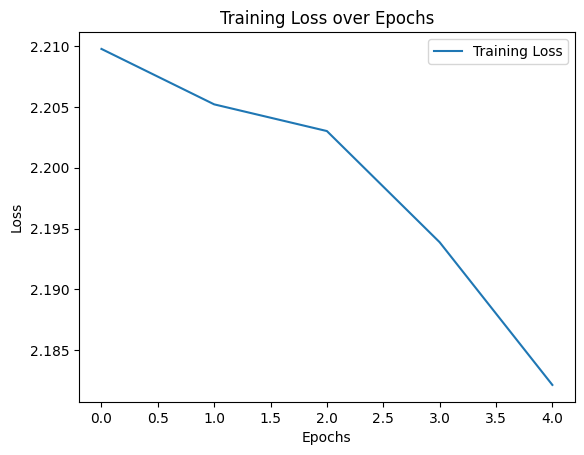

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming HAN model and train_loader are already defined
han = HAN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(han.parameters(), lr=2e-3)

num_epochs = 5
previous_epoch_loss = float('inf')
epoch_losses = []

han.train()

for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            optimizer.zero_grad()
            documents, labels = batch['document'], batch['label']
            outputs = han(documents)
            encoded_labels = []
            for label in labels:
                ex = torch.zeros(10)
                ex[int(label) - 1] = 1
                encoded_labels.append(ex)
            stacked_labels = torch.stack(encoded_labels)
            loss = criterion(outputs, stacked_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    average_loss = total_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f'Training loss: {average_loss}')

    torch.save({
    'epoch': num_epochs,
    'model_state_dict': han.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': previous_epoch_loss,
    }, 'checkpoint.pth')

    if abs(previous_epoch_loss - average_loss) < 1e-5:
        print(f'Stopping early at epoch {epoch+1} due to small loss change')
        break

    previous_epoch_loss = average_loss

# Plotting the loss function
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


In [ ]:
# Giả sử bạn đã huấn luyện xong một giai đoạn và muốn lưu lại trạng thái của mô hình và optimizer
torch.save({
    'epoch': num_epochs,
    'model_state_dict': han.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': previous_epoch_loss,
}, 'checkpoint.pth')


In [ ]:
checkpoint = torch.load('checkpoint.pth')

# Khởi tạo lại mô hình
han.load_state_dict(checkpoint['model_state_dict'])

# Khởi tạo optimizer mới (SGD) mà không tải trạng thái cũ
optimizer = optim.Adam(han.parameters(), lr=2e-4)

# Khởi động các biến cần thiết
start_epoch = checkpoint['epoch']  # epoch bắt đầu từ epoch đã lưu
previous_epoch_loss = checkpoint['loss']

# Tiếp tục huấn luyện từ epoch đã lưu
num_epochs = 20  # Số epoch bạn muốn huấn luyện thêm

han.train()

for epoch in range(start_epoch, start_epoch + num_epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        documents, labels = batch['document'], batch['label']
        outputs = han(documents)

        # Chuyển đổi labels thành one-hot encoding
        encoded_labels = []
        for label in labels:
            ex = torch.zeros(10)
            ex[int(label) - 1] = 1
            encoded_labels.append(ex)
        stacked_labels = torch.stack(encoded_labels)

        loss = criterion(outputs, stacked_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Training loss: {average_loss}')

    # Kiểm tra điều kiện dừng
    if abs(previous_epoch_loss - average_loss) < 1e-5:
        print(f'Stopping early at epoch {epoch+1} due to small loss change')
        break

    # Cập nhật loss của epoch trước đó
    previous_epoch_loss = average_loss

    # Lưu checkpoint sau mỗi epoch nếu muốn
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': han.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': previous_epoch_loss,
    }, 'checkpoint2.pth')


Training loss: 1.5166080737113952
Training loss: 1.515678882598877
Training loss: 1.5136768174171449
Training loss: 1.5116147112846374
Training loss: 1.5099074578285216
Training loss: 1.5096896624565124
Training loss: 1.5084106183052064
Training loss: 1.508151113986969
Training loss: 1.50770067691803
Training loss: 1.5074122309684754
Training loss: 1.507261905670166
Training loss: 1.507117829322815
Training loss: 1.5061391115188598
Training loss: 1.505526580810547
Training loss: 1.5052174401283265
Training loss: 1.5050672936439513
Training loss: 1.5047561454772949
Training loss: 1.5051380324363708
Training loss: 1.5043332147598267
Training loss: 1.5013388562202454


### Inference

In [28]:
han.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for batch in valid_loader:
        documents, labels = batch['document'], batch['label']
        outputs = han(documents)

        # Get the predicted labels
        predicted_labels = torch.argmax(outputs, dim=1)

        all_predictions.extend(predicted_labels)
        all_labels.extend(labels)

# Here you can add code to evaluate the predictions
# For example, calculating accuracy or other metrics

fixed_all_labels = [int(label)-1 for label in all_labels]
accuracy = sum(1 for x, y in zip(all_predictions, fixed_all_labels) if x == y) / len(all_labels)
print(f'Test accuracy: {accuracy}')

Test accuracy: 0.272


### experimenting

In [ ]:
m = nn.Linear(20, 30)
input = torch.randn(4,5,128, 20)
output = m(input)
print(output.size())


torch.Size([4, 5, 128, 30])


In [ ]:
rnn = nn.GRU(10, 20, batch_first=True, bidirectional=True)
input = torch.randn(5, 3, 10)   # (batch_size, seq_len, input_size)
h0 = torch.randn(2, 5, 20)   # (2 * num_layers, batch_size, hidden_size)
output, hn = rnn(input, h0)  # (batch_size, seq_len, 2*hidden_size)   (2, batch_size, hidden_size)


In [ ]:
print(output.size(), hn.size())

torch.Size([5, 3, 40]) torch.Size([2, 5, 20])


In [ ]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
print(input, output)

tensor([[-0.4979,  0.2947,  0.6058],
        [-0.0335,  1.1921, -0.1068]]) tensor([[0.1607, 0.3549, 0.4844],
        [0.1874, 0.6384, 0.1742]])


In [ ]:
a = torch.tensor([[1,2,3], [2,3,1]])
print(torch.argmax(a, dim=1))

tensor([2, 1])


### save model + create checkpoints

In [ ]:
save_path = 'final_model.pth'
torch.save({
    'model_state_dict': han.state_dict(),
    'loss': 2.102539749622345
}, save_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Giả sử han là mô hình của bạn và final_loss là giá trị loss cuối cùng
final_loss = 2.239507790534727  # Giả sử đây là giá trị loss cuối cùng

# Đường dẫn lưu file trên Google Drive
drive_save_path = '/content/drive/My Drive/final_model.pth'

# Lưu trọng số mô hình và giá trị loss vào Google Drive
torch.save({
    'model_state_dict': han.state_dict(),
    'loss': final_loss
}, drive_save_path)

print(f'Model weights and final loss saved to {drive_save_path}')

# Khởi tạo lại mô hình của bạn (phải giống cấu trúc mô hình đã lưu)

# Đường dẫn đến file đã lưu trên Google Drive
drive_save_path = '/content/drive/My Drive/final_model.pth'

# Tải trọng số mô hình và giá trị loss từ Google Drive
checkpoint = torch.load(drive_save_path)
han.load_state_dict(checkpoint['model_state_dict'])
final_loss = checkpoint['loss']

print(f'Model weights loaded and final loss is {final_loss}')


Mounted at /content/drive
Model weights and final loss saved to /content/drive/My Drive/final_model.pth
Model weights loaded and final loss is 2.239507790534727
